In [2]:
# dataframe opertations - pandas
import pandas as pd
import numpy as np
import time

# plotting data - matplotlib
from matplotlib import pyplot as plt

##sesonale Dekomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# holt winters
# time series - statsmodels
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import kruskal

# Trendtest
import pymannkendall as mk

# Seasonalitätstestt
from scipy import stats

# Metriken
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)

In [7]:
# Input Daten
health = pd.read_csv(
    "../../output/cut-data.csv",
    usecols=["date", "occupancy"],
    index_col="date",
    parse_dates=True,
)

health

,occupancy
date,
2017-05-01,139
2017-05-02,135
2017-05-03,133
2017-05-04,133
2017-05-05,135
...,...
2019-03-27,129
2019-03-28,141
2019-03-29,142


<Axes: title={'center': 'occupancy Data'}, xlabel='date'>

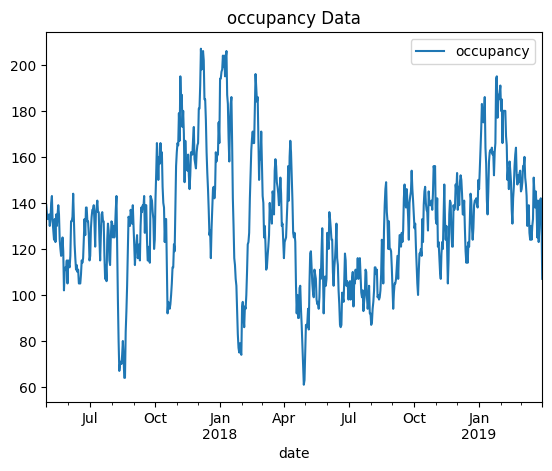

In [8]:
# plot "health"
health[["occupancy"]].plot(title="occupancy Data")

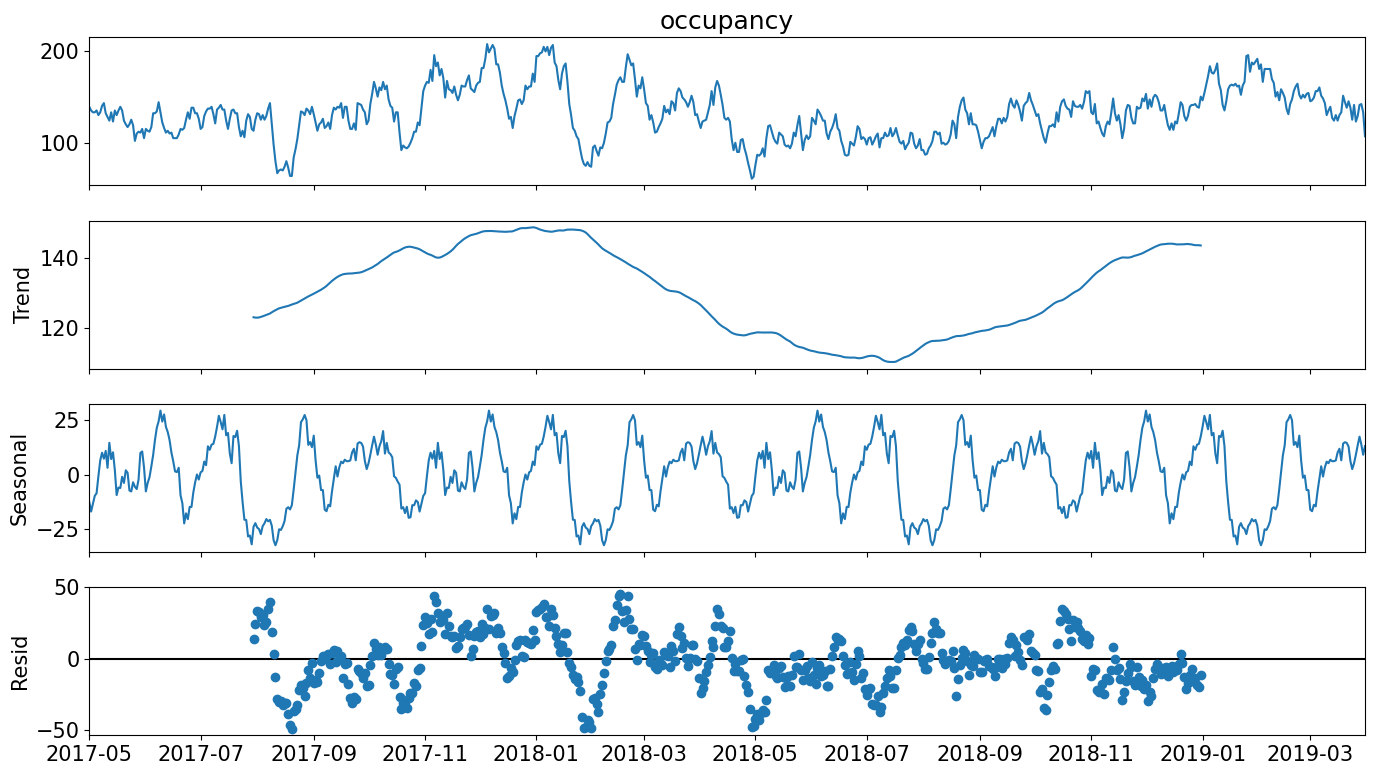

In [9]:
# sesonale Dekomposition
health.index.freq = "D"

plt.rc("figure", figsize=(14, 8))
plt.rc("font", size=15)

decompose_result = seasonal_decompose(
    health["occupancy"], model="additive", period=180
).plot()

In [10]:
# Trend Test
result = mk.original_test(health["occupancy"])
print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=6.737532587508532e-05, z=3.985369051279013, Tau=0.10066625791947681, s=24628.0, var_s=38184396.666666664, slope=0.01956521739130435, intercept=124.16195652173913)


In [11]:
# Seasonal test
res = []

health_copy = health.copy()

health_copy["month"] = health_copy.index.month

for i in health_copy.index.month.unique():
    res.append(health_copy[health_copy["month"] == i]["occupancy"].values)

result = stats.kruskal(*res)
print(result)

if result.pvalue < 0.05:  # 0.05 is the significance level
    print("High significance, deutet auf Saisonalität hin.")
else:
    print("Low significance, deutet nicht auf Saisonalität hin.")

KruskalResult(statistic=256.86384137499823, pvalue=1.0192056566119613e-48)
High significance, deutet auf Saisonalität hin.


In [12]:
# Frequenz der DateTimeIndex auf "D" für daily, weil tägliche Daten gegeben sind
health.index.freq = "D"
# Alpha  und  Zeitperiode m setzen
m = 12
alpha = 1 / (2 * m)

<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='date'>

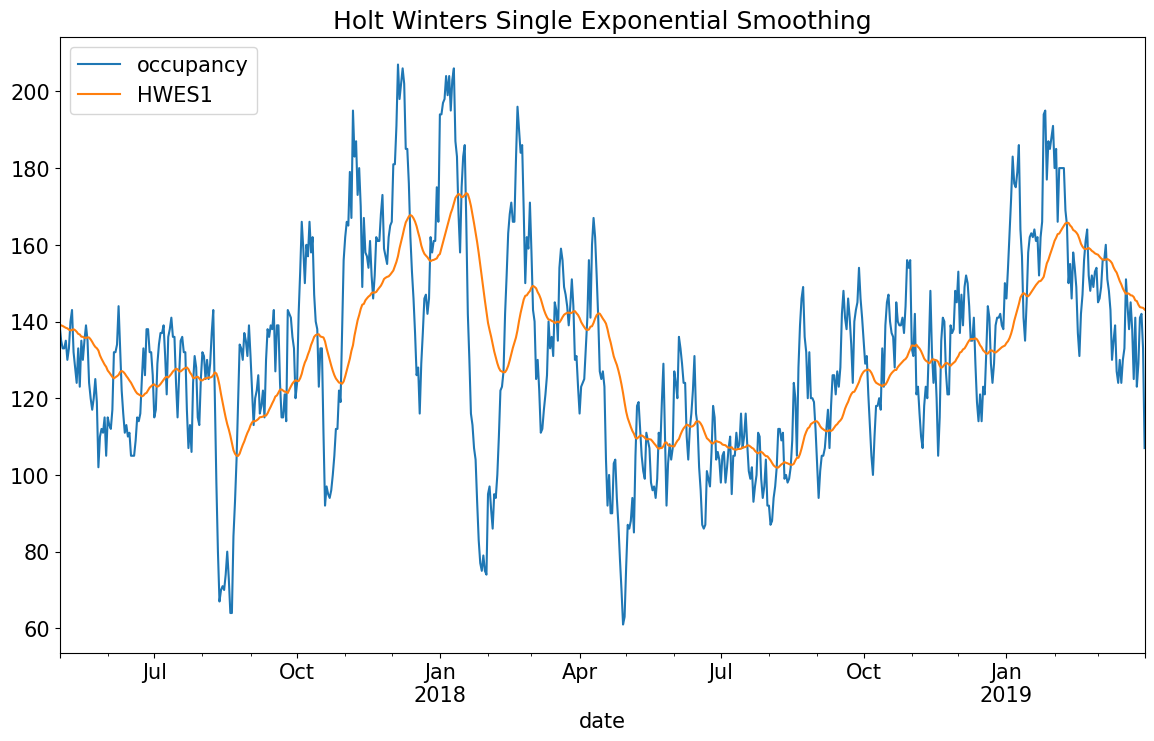

In [13]:
# Exponentielle Glättung
health["HWES1"] = (
    SimpleExpSmoothing(health["occupancy"])
    .fit(smoothing_level=alpha, optimized=False, use_brute=True)
    .fittedvalues
)


health[["occupancy", "HWES1"]].plot(
    title="Holt Winters Single Exponential Smoothing"
)

<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='dates'>

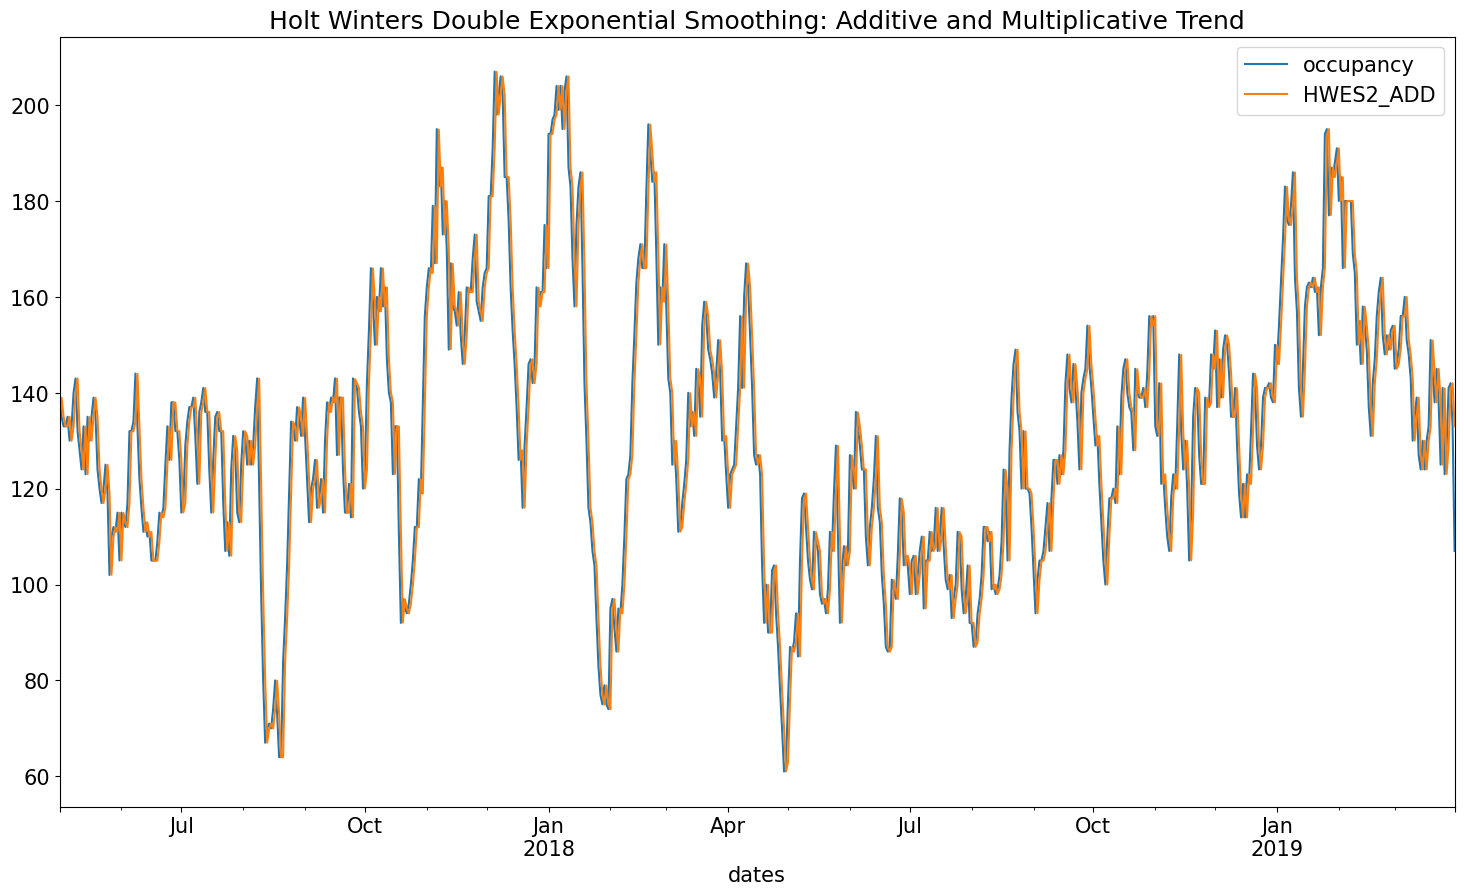

In [9]:
# Holts lineare exponentielle Glättung fitting
health["HWES2_ADD"] = (
    ExponentialSmoothing(health["occupancy"], trend="add").fit().fittedvalues
)

health["HWES2_MUL"] = ExponentialSmoothing(
    health["occupancy"], trend="mul"
).fit()

health[["occupancy", "HWES2_ADD", "HWES2_MUL"]].plot(
    title="Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend",
    figsize=(18, 10),
)

c:\Users\nguye\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='date'>

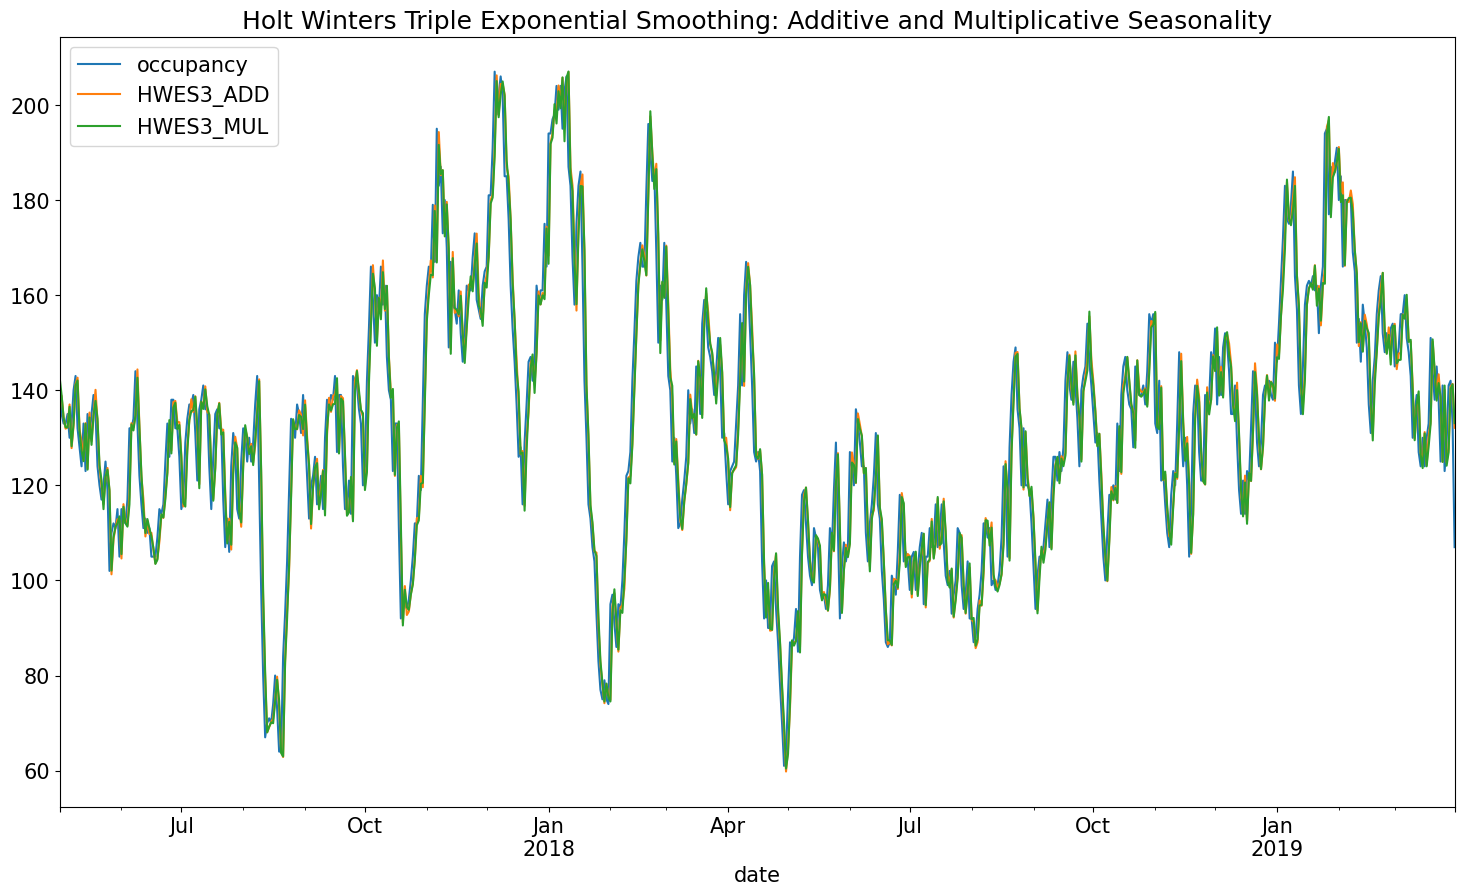

In [14]:
# Holt und Winters seasonale Methode fitting
health["HWES3_ADD"] = (
    ExponentialSmoothing(
        health["occupancy"], trend="add", seasonal="add", seasonal_periods=24
    )
    .fit()
    .fittedvalues
)

health["HWES3_MUL"] = (
    ExponentialSmoothing(
        health["occupancy"], trend="mul", seasonal="mul", seasonal_periods=24
    )
    .fit()
    .fittedvalues
)

health[["occupancy", "HWES3_ADD", "HWES3_MUL"]].plot(
    title="Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality",
    figsize=(18, 10),
)

In [63]:
# Daten nochmal importieren für Sauberkeit
health = pd.read_csv(
    "../../output/cut-data.csv",
    usecols=["date", "occupancy"],
    index_col="date",
    parse_dates=True,
)

health.index.freq = "D"

# Tage zum Vorhersagen


target_days = 30

# Parameter für das Modell
# trend: add oder mul
# damped_trend : False oder True
# seasonal: add oder mul
# seasonal_periods: Anzahl der Perioden
# initialization_method: heuristic oder estimated


holt_params = {
    "trend": "add",
    "damped_trend": False,
    "seasonal": "mul",
    "seasonal_periods": 173,
    "initialization_method": "heuristic",
}


# Trainings- und Testdaten


train_health = health[0 : len(health) - target_days]


test_health = health[len(health) - target_days : len(health)]

In [13]:
# Definieren der Parameterbereiche
smoothing_levels = np.arange(0.5, 0.90, 0.01)
smoothing_trends = np.arange(0.00, 0.50, 0.01)
smoothing_seasonals = np.arange(0.00, 0.60, 0.01)

# Variablen für die Speicherung des besten Ergebnisses
best_score = float("inf")
best_params = {}

# Grid Search über die Parameterbereiche
for level in smoothing_levels:
    for trend in smoothing_trends:
        for seasonal in smoothing_seasonals:
            model = ExponentialSmoothing(
                train_health["occupancy"], **holt_params
            ).fit(
                smoothing_level=level,
                smoothing_trend=trend,
                smoothing_seasonal=seasonal,
                optimized=False,
            )
            predictions = model.forecast(len(test_health))
            rmse = root_mean_squared_error(test_health, predictions)

            # Update der besten Parameter, wenn der aktuelle rmse kleiner ist
            if rmse < best_score:
                best_score = rmse
                best_params = {
                    "smoothing_level": level,
                    "smoothing_trend": trend,
                    "smoothing_seasonal": seasonal,
                }

print("Best Parameters:", best_params)

Best Parameters: {'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': 0.02}


Mean Squared Error = 144.46666666666667
Mean Absolute Error = 10.133333333333333
Root Mean Squared Error = 12.019428716318703
Mean Absolute Percentage Error = 0.07357562325544437


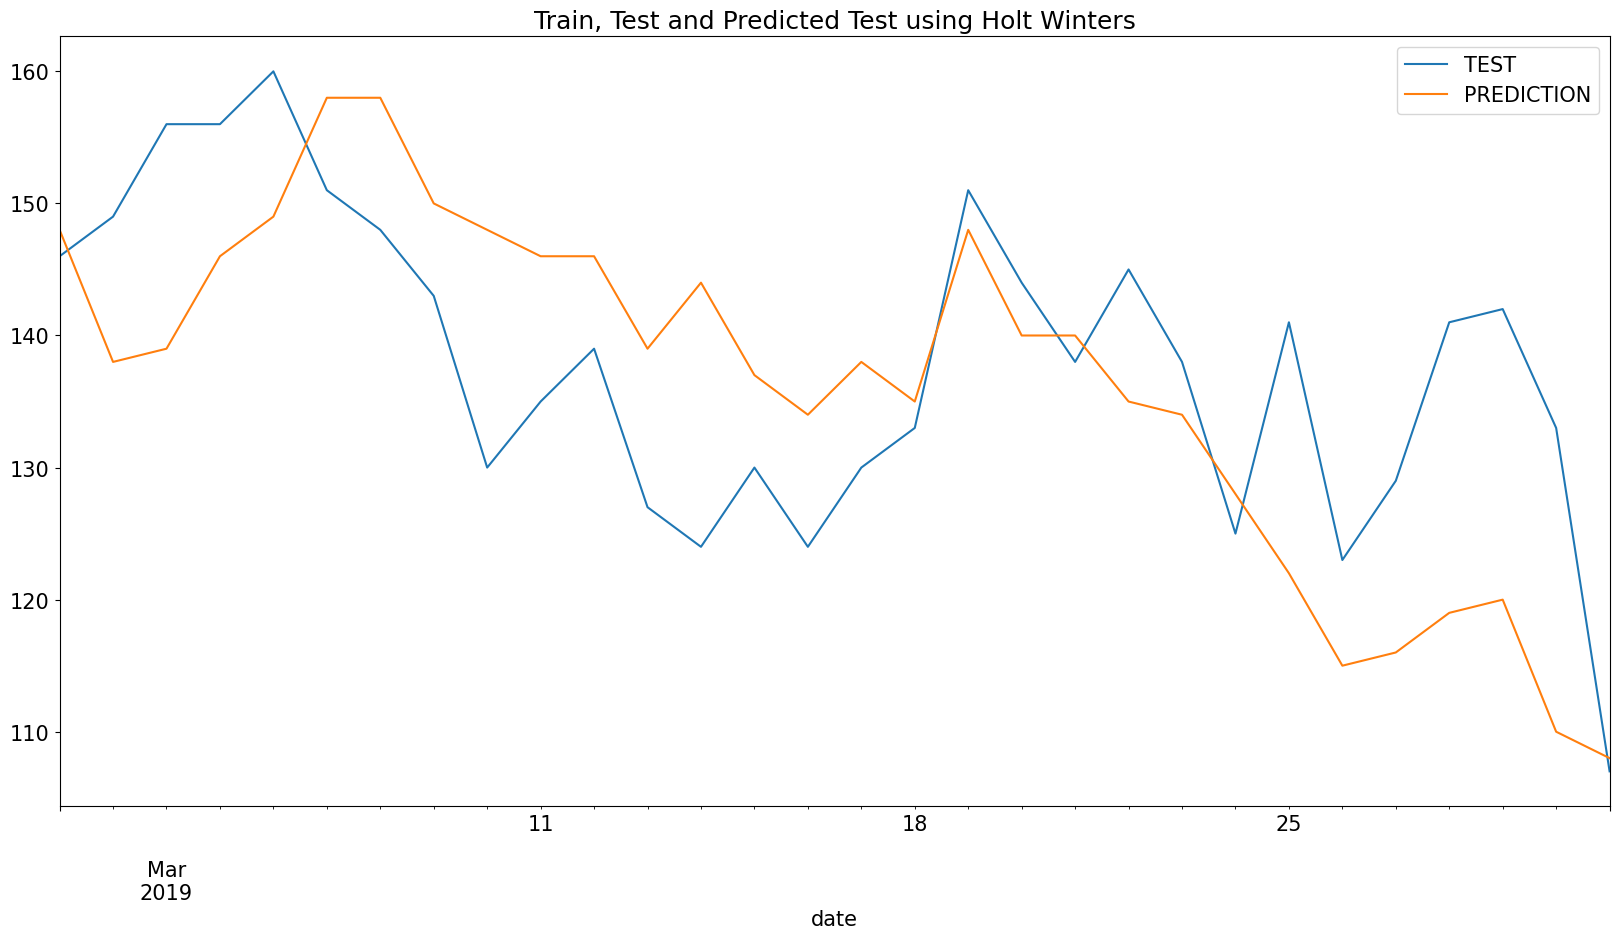

In [37]:
# Modell mit den besten Parametern aus dem Grid Search
fitted_model = ExponentialSmoothing(
    train_health["occupancy"], **holt_params
).fit(
    smoothing_level=0.53,
    smoothing_trend=0.01,
    smoothing_seasonal=0.02,
    optimized=False,
)
# Vorhersage


test_predictions = fitted_model.forecast(target_days)

# Resultate als integer


test_predictions = test_predictions.astype(int)

# Plotten der Vorhersage und der Testdaten


test_health["occupancy"].plot(legend=True, label="TEST", figsize=(20, 10))


test_predictions.plot(legend=True, label="PREDICTION")


plt.title("Train, Test and Predicted Test using Holt Winters")

# Metriken anzeigen für Modellgüte

print(
    f"Mean Squared Error = {mean_squared_error(test_health,test_predictions)}"
)
print(
    f"Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}"
)
print(
    f"Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}"
)
print(
    f"Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}"
)

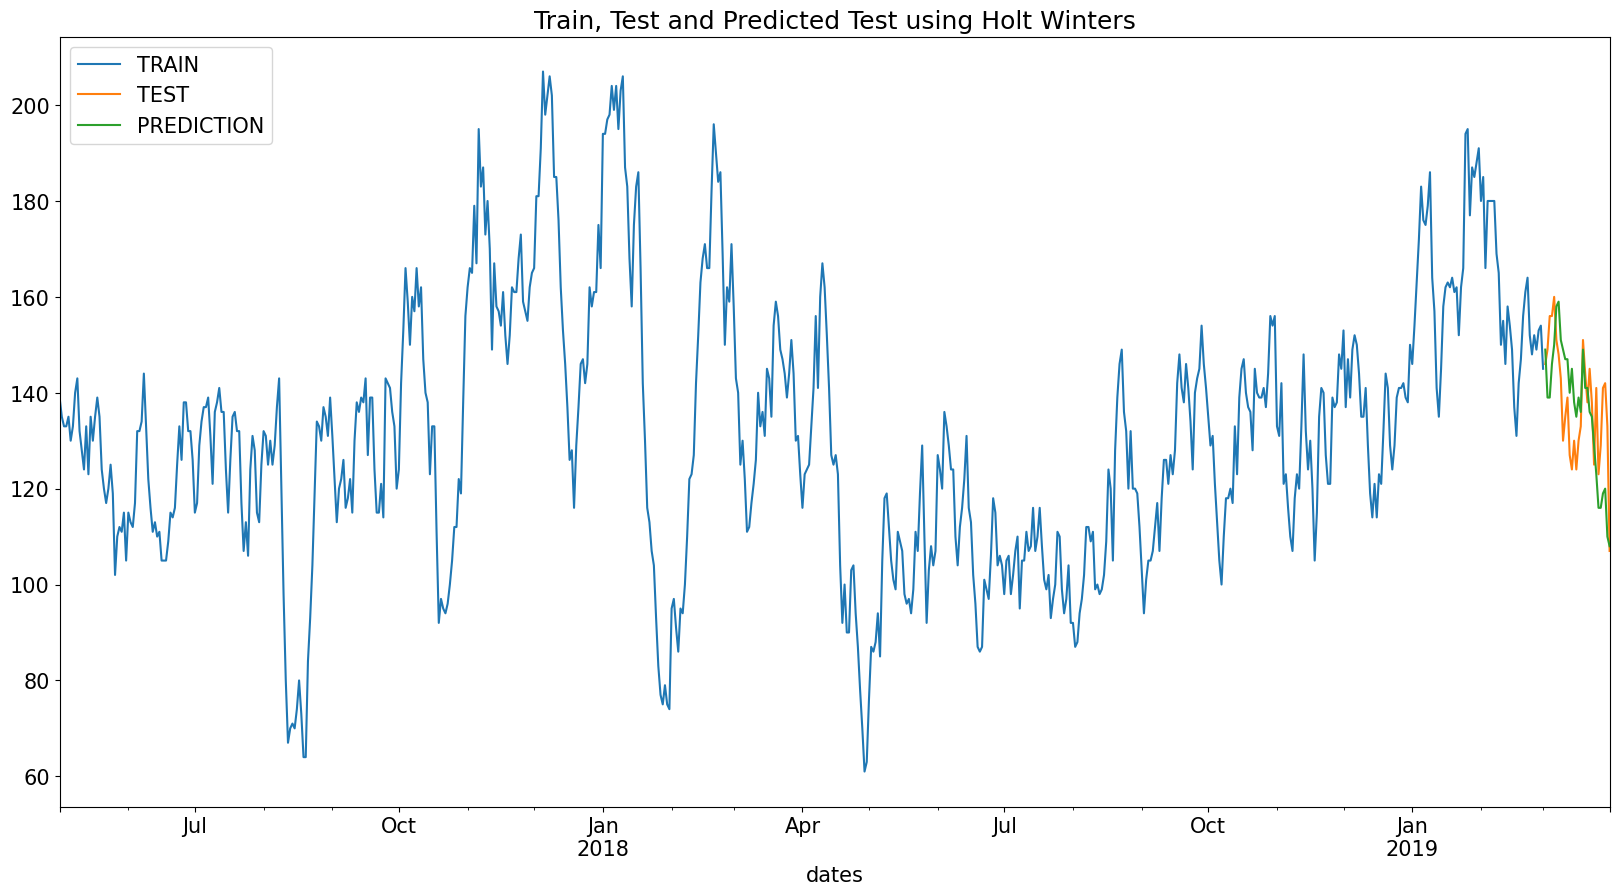

In [15]:
plt.figure(figsize=(20, 10))  # Größe des Plots anpassen

# Trainingsdaten plotten
train_health["occupancy"].plot(legend=True, label="TRAIN")

# Testdaten plotten
test_health["occupancy"].plot(legend=True, label="TEST")

# Vorheresage plotten
test_predictions.plot(legend=True, label="PREDICTION")

plt.title("Train, Test and Predicted Test using Holt Winters")
plt.show()

In [ ]:
# CSV mit den Vorhersagen erstellen
unix_timestamp = int(time.time())
 output_file = (
    '../output/holt_winter/holt-winter-%d.csv' % unix_timestamp
)


In [ ]:
# CSV mit den Parametern und Vorhersagen befüllen
out = f"target_days: {target_days}\n"
out = out + "parameters: \n"
for i in holt_params:
    out = out + (f"{i}: {holt_params[i]}\n")
for j in best_parms:
    out = out + (f"{j}: {best_params[j]}\n")
out = out + (
    f"Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}\n"
)
out = out + (
    f"Mean Squared Error = {mean_squared_error(test_health,test_predictions)}\n"
)
out = out + (
    f"Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}\n"
)
out = out + (
    f"Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}\n"
)

out = out + "dates" + "," + "occupancy" + "\n"

for i in range(len(test_predictions)):
    out = (
        out
        + str(
            (
                train_health.index[len(train_health) - 1] + pd.DateOffset(i)
            ).date()
        )
        + ","
        + str(test_predictions.iloc[i])
        + "\n"
    )

with open(output_file, "w") as f:
    f.write(out)

Sinus Kurven Test

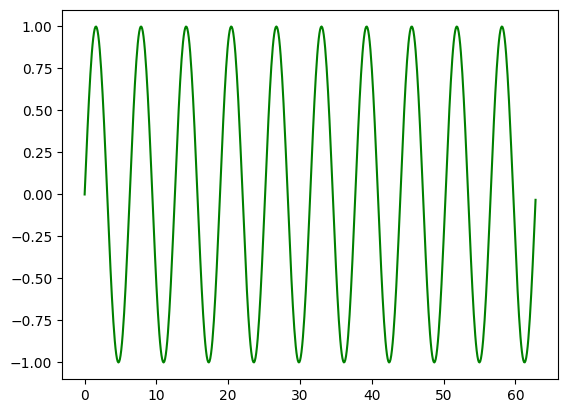

In [26]:
# Sinuskurve generieren und Plotten
x = np.arange(0, 20 * np.pi, 0.1)


sinus = np.sin(x)


plt.plot(x, sinus, color="green")


plt.show()

In [27]:
# Zeitraum definieren
start_date = "2024-01-01"
end_date = "2025-01-01"
dates = pd.date_range(start=start_date, end=end_date)

# Sinusdaten generieren
amplitude = 1  # Amplitude der Sinuskurve
frequency = 0.1  # Frequent der Sinus Kurve
phase = 0  # Phase shift of the sinus wave
sinus_data = amplitude * np.sin(
    np.pi * frequency * np.arange(len(dates)) + phase
)


# Dateframe mit Sinusdaten erstellen
df = pd.DataFrame({"Date": dates, "Sinus_Value": sinus_data})
df.set_index("Date", inplace=True)

# Tabellenkopf ausgeben
print(df.head())

            Sinus_Value
Date                   
2024-01-01     0.000000
2024-01-02     0.309017
2024-01-03     0.587785
2024-01-04     0.809017
2024-01-05     0.951057


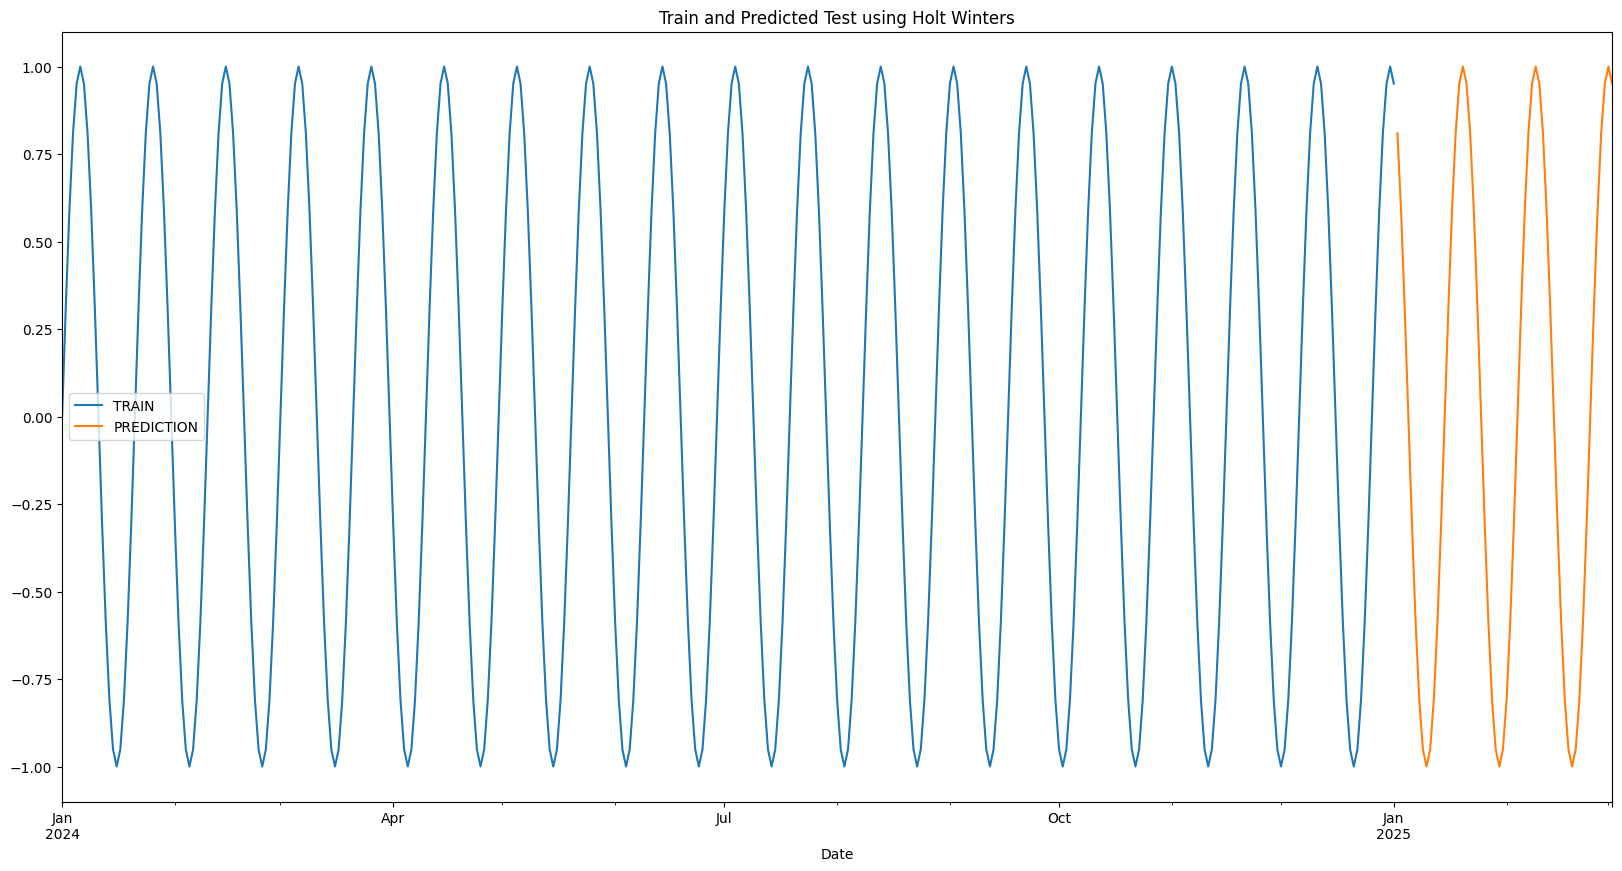

In [ ]:
df.index.freq = "D"

sinus_model = ExponentialSmoothing(
    df["Sinus_Value"], trend=None, seasonal="add", seasonal_periods=60
).fit()

predictions_sinus = sinus_model.forecast(60)

plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot the training data
df["Sinus_Value"].plot(legend=True, label="TRAIN")

# Plot the test data
predictions_sinus.plot(legend=True, label="PREDICTION")


plt.title("Train and Predicted Test using Holt Winters")
plt.show()  # Show the plot